In [3]:
import torch
from gpytorch.kernels import ScaleKernel
from abc import ABC, abstractmethod
import gpytorch
import os
import sys
# import jax.numpy as jnp
# from jax.nn import softplus, sigmoid
from typing import Callable
# from optax import OptState, adam, apply_updates

# Data path setup
notebook_dir = os.getcwd()
src_path = os.path.abspath(os.path.join(notebook_dir, '../code'))
if src_path not in sys.path:
    sys.path.append(src_path)
from util import train, eval, plot_gpr_results, memory_dump, fetch_uci_dataset
import sys

In [4]:
train_data, train_labels, test_data, test_labels = fetch_uci_dataset('protein',r"C:\Users\fredw\chris\Research\softki\data\uci_datasets\uci_datasets\protein\data.csv",train_frac=9/10,val_frac=0/20)
from torch.utils.data import DataLoader, TensorDataset
print(train_data.shape)
batch_size=1024
# Creating dataset and dataloader
train_dataset = TensorDataset(train_data, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

lr=.01

SIZE (45730, 10)
Dataset loaded
torch.Size([41157, 9])


C:\Users\fredw\AppData\Local\Temp\ipykernel_38292\786368227.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


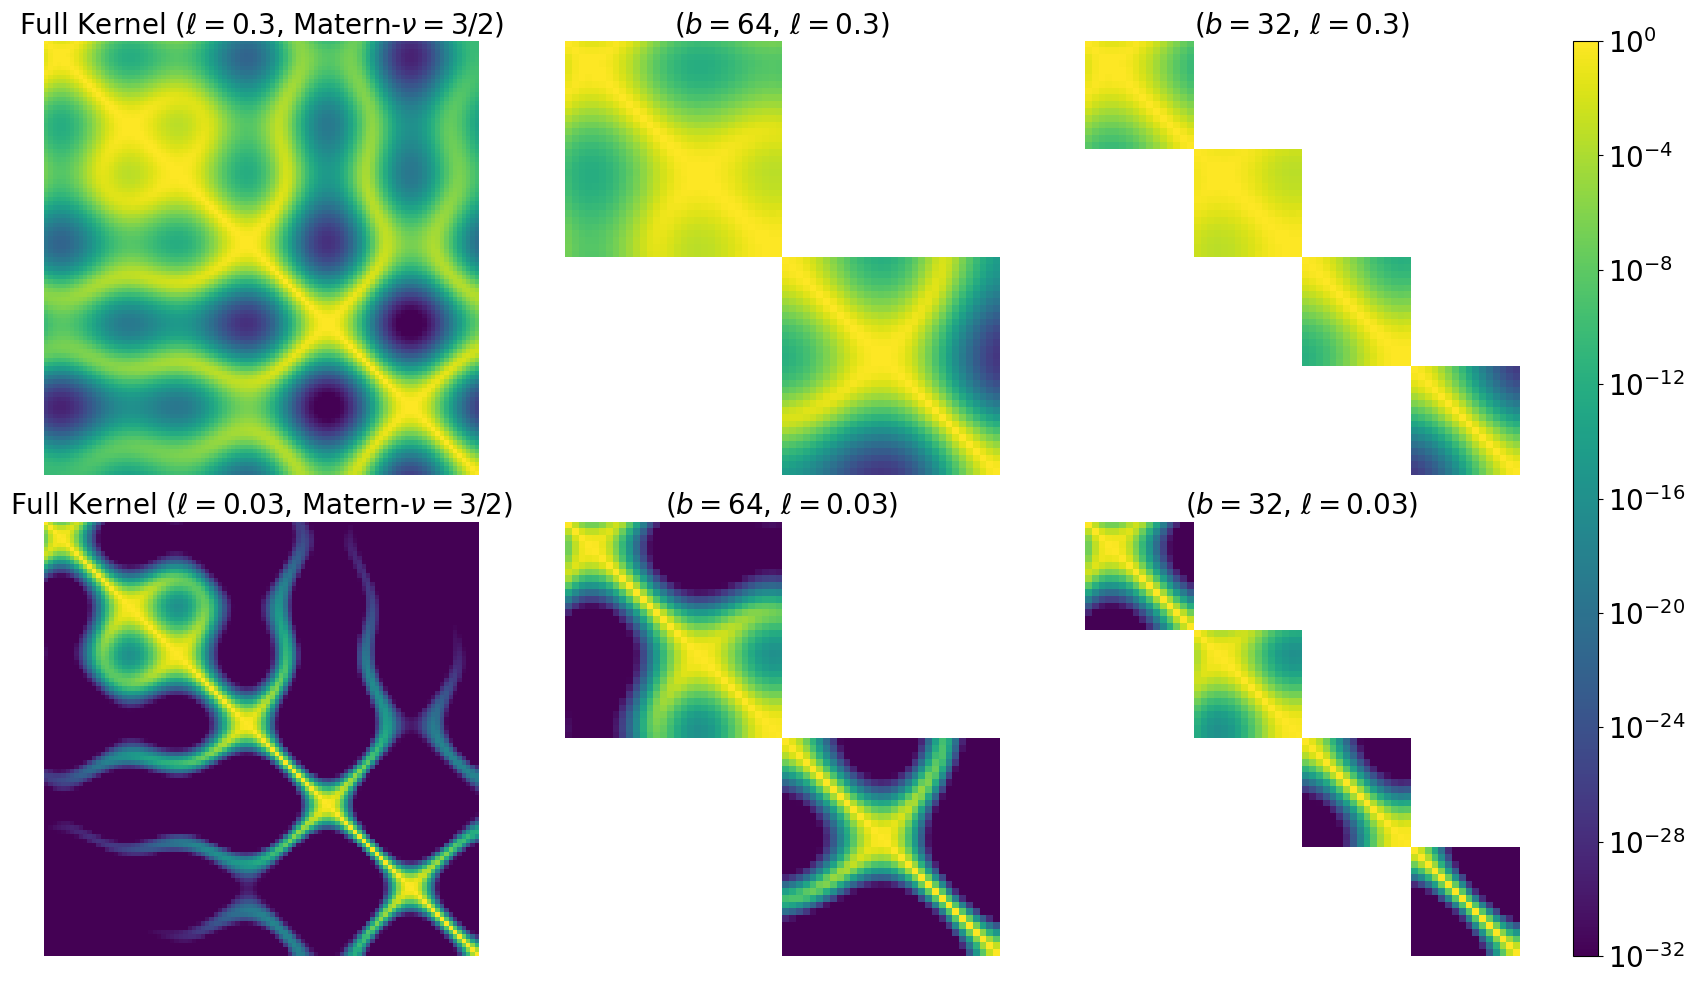

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy.ma as ma
import copy
from sklearn.gaussian_process.kernels import Matern  # Updated kernel import
from scipy.linalg import block_diag
import matplotlib.colors as mcolors
from matplotlib import cm  # Needed for colormap truncation

# Function to truncate colormap
def truncate_colormap(cmap_name, min_val=0.25, max_val=1.0):
    cmap = cm.get_cmap(cmap_name)
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
        f"trunc({cmap_name},{min_val},{max_val})",
        cmap(np.linspace(min_val, max_val, 256))
    )
    return new_cmap

# Create the truncated viridis colormap
truncated_cmap = truncate_colormap("Spectral", .2, 0.7)

# # Generate synthetic data using linspace instead of Gaussian random
# n = 64  # Number of points
# X = np.linspace(0, 20, n).reshape(-1, 1)

# # Define noise level; adjust sigma as needed
# sigma = 0.05
# noise = sigma * np.random.randn(n)

# # Create 2D points with noisy function evaluations
# x = np.linspace(0, 2 * np.pi, 100)
# noise = np.random.normal(0, 0.01, size=x.shape)
# output_scale = 5  # Example output scale parameter

# # Compute the noisy function values
# noisy_y = output_scale * (np.sin(2 * x) + np.cos(3 * x)) + noise

# X = np.column_stack((x, noisy_y))
# Define two Matern 3/2 kernels with different length scales
kernel_top = Matern(length_scale=0.3, nu=1.5)
kernel_bottom = Matern(length_scale=0.1, nu=1.5)
train_x
# Compute the full kernel matrices for each row
full_kernel_top = kernel_top(X)
full_kernel_bottom = kernel_bottom(X)

# Create block-diagonal approximations for the top row
batch_size_top1 = 32
num_batches_top1 = n // batch_size_top1
blocks_top1 = [kernel_top(X[i * batch_size_top1:(i + 1) * batch_size_top1])
               for i in range(num_batches_top1)]
block_diag_kernel_top1 = block_diag(*blocks_top1)

batch_size_top2 = 16
num_batches_top2 = n // batch_size_top2
blocks_top2 = [kernel_top(X[i * batch_size_top2:(i + 1) * batch_size_top2])
               for i in range(num_batches_top2)]
block_diag_kernel_top2 = block_diag(*blocks_top2)

# Create block-diagonal approximations for the bottom row
batch_size_bottom1 = 32
num_batches_bottom1 = n // batch_size_bottom1
blocks_bottom1 = [kernel_bottom(X[i * batch_size_bottom1:(i + 1) * batch_size_bottom1])
                  for i in range(num_batches_bottom1)]
block_diag_kernel_bottom1 = block_diag(*blocks_bottom1)

batch_size_bottom2 = 16
num_batches_bottom2 = n // batch_size_bottom2
blocks_bottom2 = [kernel_bottom(X[i * batch_size_bottom2:(i + 1) * batch_size_bottom2])
                  for i in range(num_batches_bottom2)]
block_diag_kernel_bottom2 = block_diag(*blocks_bottom2)

# Compute a global normalization for all images
def compute_global_norm(*arrays):
    combined = np.concatenate([a.ravel() for a in arrays])
    positive_vals = combined[combined > 0]
    vmin = positive_vals.min() if positive_vals.size > 0 else 1e-8
    vmax = combined.max()
    return vmin, vmax

global_vmin, global_vmax = compute_global_norm(
    full_kernel_top, block_diag_kernel_top1, block_diag_kernel_top2,
    full_kernel_bottom, block_diag_kernel_bottom1, block_diag_kernel_bottom2
)

# Truncate the color bar lower limit to 10^-32
global_vmin = max(global_vmin, 1e-32)

# Prepare a colormap that plots masked values in white
cmap = copy.copy(plt.get_cmap('viridis'))
cmap.set_bad(color='white')

def prepare_imshow_data(data):
    # Mask zero entries so they appear white
    return ma.masked_equal(data, 0)

# Create figure and gridspec with an extra column for the colorbar
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 4, width_ratios=[1, 1, 1, 0.05])
# Create axes for the 2x3 grid of images
ax00 = fig.add_subplot(gs[0, 0])
ax01 = fig.add_subplot(gs[0, 1])
ax02 = fig.add_subplot(gs[0, 2])
ax10 = fig.add_subplot(gs[1, 0])
ax11 = fig.add_subplot(gs[1, 1])
ax12 = fig.add_subplot(gs[1, 2])
# Create an axis for the colorbar (spanning both rows)
cbar_ax = fig.add_subplot(gs[:, 3])

# Top row plots (length scale = 0.3, Matern 3/2)
im0 = ax00.imshow(prepare_imshow_data(full_kernel_top), cmap=cmap,
                   norm=LogNorm(vmin=global_vmin, vmax=global_vmax), aspect='equal')
ax00.set_title(r"Full Kernel ($\ell=0.3$, Matern-$\nu=3/2$)", fontsize=20)
ax00.axis('off')

im1 = ax01.imshow(prepare_imshow_data(block_diag_kernel_top1), cmap=cmap,
                   norm=LogNorm(vmin=global_vmin, vmax=global_vmax), aspect='equal')
ax01.set_title(r"($b=64$, $\ell=0.3$)", fontsize=20)
ax01.axis('off')

im2 = ax02.imshow(prepare_imshow_data(block_diag_kernel_top2), cmap=cmap,
                   norm=LogNorm(vmin=global_vmin, vmax=global_vmax), aspect='equal')
ax02.set_title(r"($b=32$, $\ell=0.3$)", fontsize=20)
ax02.axis('off')

# Bottom row plots (length scale = 0.03, Matern 3/2)
im3 = ax10.imshow(prepare_imshow_data(full_kernel_bottom), cmap=cmap,
                   norm=LogNorm(vmin=global_vmin, vmax=global_vmax), aspect='equal')
ax10.set_title(r"Full Kernel ($\ell=0.03$, Matern-$\nu=3/2$)", fontsize=20)
ax10.axis('off')

im4 = ax11.imshow(prepare_imshow_data(block_diag_kernel_bottom1), cmap=cmap,
                   norm=LogNorm(vmin=global_vmin, vmax=global_vmax), aspect='equal')
ax11.set_title(r"($b=64$, $\ell=0.03$)", fontsize=20)
ax11.axis('off')

im5 = ax12.imshow(prepare_imshow_data(block_diag_kernel_bottom2), cmap=cmap,
                   norm=LogNorm(vmin=global_vmin, vmax=global_vmax), aspect='equal')
ax12.set_title(r"($b=32$, $\ell=0.03$)", fontsize=20)
ax12.axis('off')

plt.tight_layout(rect=[0, 0, 0.9, 1])
cbar = fig.colorbar(im0, cax=cbar_ax)
cbar.ax.tick_params(labelsize=20)

# Note: plt.show() is not called to avoid plotting in non-interactive environments.

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Assume the following have been defined:
# def true_function(x):
#     return torch.sin(2 * x) + torch.cos(3 * x)
#
def generate_data(true_function, train_range=(-3, 3), test_range=(-3, 3), 
                  n_train=40, n_test=100, noise_std=0.1, 
                  device='cuda:0', dtype=torch.float64):
    # ... code as before ...
    return X_train, y_train.squeeze(), X_test, y_test.squeeze()

And that global_dtype is defined:
global_dtype = torch.float64

# Generate data using the true function over the test range (-5, 5)
train_x, train_y, test_x, test_y = generate_data(true_function, test_range=(-5, 5), dtype=global_dtype)

# Convert PyTorch tensors to NumPy arrays for plotting
train_x_np = train_x.cpu().numpy().squeeze()
train_y_np = train_y.cpu().numpy().squeeze()
test_x_np  = test_x.cpu().numpy().squeeze()
test_y_np  = test_y.cpu().numpy().squeeze()

# Mimic a GP prediction using the true function values scaled by an output factor.
output_scale = 5
GP_mean = output_scale * test_y_np  # GP mean prediction (scaled true function)
std = 0.2  # constant uncertainty

# For demonstration, use the training data (with noise) as noisy observations.
# Also, prepare a placeholder 2D kernel to display.
kernel_size = 50
kernel_data = np.random.rand(kernel_size, kernel_size)

# Set up the figure using a 4x4 GridSpec.
fig = plt.figure(figsize=(8, 8))
gs = fig.add_gridspec(4, 4, wspace=0.05, hspace=0.05)

# The top axis (ax_top) displays the 1D function with uncertainty.
ax_top  = fig.add_subplot(gs[0, 1:])
# The left axis (ax_left) displays the same function oriented vertically.
ax_left = fig.add_subplot(gs[1:, 0])
# The main axis (ax_main) shows the 2D kernel.
ax_main = fig.add_subplot(gs[1:, 1:])

# Plot the GP prediction and uncertainty on the top subplot.
ax_top.fill_between(
    test_x_np,
    GP_mean - std,
    GP_mean + std,
    color='navy',
    alpha=0.2,
    label='Uncertainty'
)
ax_top.plot(test_x_np, GP_mean, color='navy', label='Mean')
ax_top.scatter(
    train_x_np, output_scale * train_y_np,  # scale training outputs for consistency
    s=40,
    color='darkorange',
    edgecolors='black',
    zorder=3,
    label='Noisy Observations'
)
ax_top.legend(loc='upper right')
ax_top.set_ylabel("f(x)")
ax_top.set_xticklabels([])  # remove x-axis tick labels

# Plot the vertically oriented function on the left subplot.
ax_left.fill_betweenx(
    test_x_np,
    GP_mean - std,
    GP_mean + std,
    color='navy',
    alpha=0.2
)
ax_left.plot(GP_mean, test_x_np, color='navy')
ax_left.scatter(
    output_scale * train_y_np, train_x_np,
    s=40,
    color='darkorange',
    edgecolors='black',
    zorder=3
)
ax_left.invert_xaxis()  # invert x-axis so the filled region appears correctly
ax_left.set_xlabel("f(x)")
ax_left.set_yticklabels([])  # remove y-axis tick labels

# Display the 2D kernel using imshow on the main subplot.
im = ax_main.imshow(
    kernel_data,
    origin='lower',
    aspect='auto',
    cmap='viridis'
)
cbar = plt.colorbar(im, ax=ax_main, fraction=0.046, pad=0.04)
cbar.set_label("Kernel Value")

# Finally, show the complete figure.
plt.show()

SyntaxError: invalid syntax (3059886145.py, line 15)

In [ ]:
import jax
import jaxlib

print("JAX version:", jax.__version__)
print("JAXLIB version:", jaxlib.__version__)
print("Devices:", jax.devices())

JAX version: 0.5.1
JAXLIB version: 0.5.1
Devices: [CpuDevice(id=0)]


### Experiment 1 
The goal of this experiment, is to simply instantiate a gaussian process with the new libraries and run CG of any king 
this should force some refactoring to happen with the new code base

In [ ]:
from typing import NamedTuple

class TrainConfig(NamedTuple):
    seed: int

    dataset_name: str
    dataset_split: int
    n_subsample: int
    subsample_seed: int

    kernel_name: str
    n_features: int

    pretrained_init: bool
    noise_scale_init: float
    signal_scale_init: float
    length_scale_init: float

    noise_scale_min: float

    n_iterations: int
    learning_rate: float

    estimator_name: str
    warm_start: bool
    n_samples: int
    pathwise_init: bool

    solver_name: str
    rtol_y: float
    rtol_z: float
    max_epochs: int

    batch_size: int

    log_wandb: bool
    log_verbose: bool
    log_metrics_exact: bool
    log_metrics_samples: bool

    checkpoint_interval: int

cfg = TrainConfig(
    seed=12345,
    dataset_name=None,
    dataset_split=None,
    n_subsample=None,
    subsample_seed=None,
    kernel_name=None,
    n_features=200,
    pretrained_init=False,
    noise_scale_init=1.0,
    signal_scale_init=1.0,
    length_scale_init=1.0,
    noise_scale_min=0.0,
    n_iterations=100,
    learning_rate=0.1,
    estimator_name="pathwise",
    warm_start=True,
    n_samples=16,
    pathwise_init=False,
    solver_name="sgd",
    rtol_y=0.01,
    rtol_z=0.01,
    max_epochs=1000,
    batch_size=100,
    log_wandb=False,
    log_verbose=True,
    log_metrics_exact=True,
    log_metrics_samples=True,
    checkpoint_interval=0,)

In [ ]:
class Positive():
    def __init__(self, initial_value=1e-3):
        # Store noise as a learnable parameter in log-space to enforce positivity
        self.raw_value = nn.Parameter(torch.tensor(initial_value).log())  
    
    def get_value(self):
        """Ensure noise is always positive by exponentiating raw_value"""
        return torch.exp(self.raw_value)
        
class AbstractGaussianProcess(ABC):
    def __init__(self, kernel, noise=.1, dtype=torch.float, device="cuda:0"):
        self.dtype = dtype
        self.device = device
        self.kernel = kernel.to(dtype=dtype, device=self.device)
        
        # Use  constraint on noise
        self.noise = Positive(initial_value=noise)
        
        self.X_train = None
        self.alpha = None
        self.L = None

    @abstractmethod
    def fit(self, X, y):
        pass

    @abstractmethod
    def predict(self, X):
        pass

In [ ]:
def fit(
    train_ds,
    test_ds,
    kernel_fn,
    kernel_grad_fn,
    feature_params_fn,
    gradient_estimator,
    solver,
    cfg,
    transform_fn: Callable = softplus,
    transform_grad_fn: Callable = sigmoid,
    transform_inv_fn: Callable = lambda x: jnp.log(jnp.exp(x) - 1.0),
):
    if cfg.estimator_name not in ["exact", "standard", "pathwise"]:
        raise ValueError(f"Unknown estimator name {cfg.estimator_name}")

    # Partially apply estimator parameters.
    gradient_estimator = partial(
        gradient_estimator,
        ds=train_ds,
        kernel_fn=kernel_fn,
        kernel_grad_fn=kernel_grad_fn,
        feature_params_fn=feature_params_fn,
        n_features=cfg.n_features,
        warm_start=cfg.warm_start,
        solver=solver,
        rtol_y=cfg.rtol_y,
        rtol_z=cfg.rtol_z,
        max_epochs=cfg.max_epochs,
        batch_size=cfg.batch_size,
    )

    float_cast = jnp.float64 if jax_config.read('jax_enable_x64') else jnp.float32
    print("Using float64" if jax_config.read('jax_enable_x64') else "Using float32")

    noise_scale_u_min = (
        transform_inv_fn(cfg.noise_scale_min) if cfg.noise_scale_min > 0.0 else -jnp.inf
    )
    optimiser = adam(learning_rate=-cfg.learning_rate)

    # Initialization (always cold start)
    if cfg.pretrained_init:
        pretrained = jnp.load("./download/pretrained.npy", allow_pickle=True).item()
        model_params_init = pretrained[cfg.dataset_name][cfg.dataset_split]
    else:
        kernel_params_init = KernelParams(
            signal_scale=cfg.signal_scale_init,
            length_scale=jnp.array(train_ds.D * [cfg.length_scale_init]),
        )
        model_params_init = ModelParams(
            noise_scale=cfg.noise_scale_init, kernel_params=kernel_params_init
        )
    model_params_init = jax.tree_map(float_cast, model_params_init)
    print("Initial model_params:")
    print(model_params_init)
    model_params_u = jax.tree_map(transform_inv_fn, model_params_init)
    opt_state = optimiser.init(model_params_u)

    if cfg.estimator_name == "exact":
        train_state = None
    else:
        key = jr.PRNGKey(cfg.seed)
        v0 = jnp.zeros((train_ds.N, cfg.n_samples + 1))
        if cfg.warm_start:
            if cfg.estimator_name == "standard":
                key, z_key = jr.split(key)
                z = jr.normal(z_key, shape=(train_ds.N, cfg.n_samples))
                train_state = TrainState(
                    key=key, v0=v0, z=z, feature_params=None, w=None, eps=None
                )
            elif cfg.estimator_name == "pathwise":
                if cfg.pathwise_init:
                    train_state = jnp.load(
                        "./download/pathwise_init.npy", allow_pickle=True
                    ).item()[cfg.dataset_name][cfg.dataset_split]
                else:
                    key, feature_params_key, w_key, eps_key = jr.split(key, 4)
                    feature_params = feature_params_fn(
                        feature_params_key, train_ds.D, cfg.n_features
                    )
                    w = jr.normal(w_key, shape=(cfg.n_features, cfg.n_samples))
                    eps = jr.normal(eps_key, shape=(train_ds.N, cfg.n_samples))
                    train_state = TrainState(
                        key=key, v0=v0, z=None, feature_params=feature_params, w=w, eps=eps
                    )
        else:
            train_state = TrainState(
                key=key, v0=v0, z=None, feature_params=None, w=None, eps=None
            )
    train_state = jax.tree_map(
        lambda x: float_cast(x)
        if isinstance(x, Array) and jnp.issubdtype(x, jnp.floating)
        else x,
        train_state,
    )

    train_time = 0.0
    solver_time = 0.0
    eval_time = 0.0
    i_init = 0

    @jax.jit
    def _transform(model_params_u: ModelParams):
        return jax.tree_map(transform_fn, model_params_u)

    @jax.jit
    def _update(
        model_params_u: ModelParams, mll_grad: ModelParams, opt_state: OptState
    ):
        transform_grad = jax.tree_map(transform_grad_fn, model_params_u)
        grad = jax.tree_map(jnp.multiply, mll_grad, transform_grad)

        updates, opt_state = optimiser.update(grad, opt_state)
        model_params_u = apply_updates(model_params_u, updates)

        noise_scale_u_clipped = jnp.clip(
            model_params_u.noise_scale, a_min=noise_scale_u_min, a_max=None
        )
        model_params_u = ModelParams(
            noise_scale=noise_scale_u_clipped,
            kernel_params=model_params_u.kernel_params,
        )
        return model_params_u, opt_state

    def update(
        train_state: TrainState, model_params_u: ModelParams, opt_state: OptState
    ):
        model_params = _transform(model_params_u)
        (
            train_state,
            mll_grad,
            solver_iters,
            solver_time_i,
            r_norm_y,
            r_norm_z,
        ) = gradient_estimator(train_state=train_state, model_params=model_params)

        model_params_u, opt_state = _update(model_params_u, mll_grad, opt_state)

        return (
            train_state,
            model_params_u,
            opt_state,
            solver_iters,
            solver_time_i,
            r_norm_y,
            r_norm_z,
        )

    def log(i, model_params_u, train_time, solver_time, solver_iters, r_norm_y, r_norm_z):
        model_params = _transform(model_params_u)
        if cfg.log_metrics_exact:
            mll, train_rmse, train_llh, test_rmse, test_llh = compute_metrics_exact(
                train_ds, test_ds, kernel_fn, model_params
            )
        if cfg.log_verbose:
            info_str = f"i: {i}, "
            if cfg.log_metrics_exact:
                info_str += (
                    f"mll: {mll:.4f}, train_rmse: {train_rmse:.4f}, "
                    f"train_llh: {train_llh:.4f}, test_rmse: {test_rmse:.4f}, "
                    f"test_llh: {test_llh:.4f}, "
                )
            info_str += f"train_time: {train_time:.2f}"
            if cfg.estimator_name != "exact":
                info_str += f", solver_time: {solver_time:.2f}"
                if cfg.solver_name != "cholesky":
                    info_str += (
                        f", solver_iters: {solver_iters}, "
                        f"r_norm_y: {r_norm_y:.4f}, r_norm_z: {r_norm_z:.4f}"
                    )
            print(info_str)

    running_pred = (cfg.estimator_name == "pathwise") and cfg.log_metrics_samples
    if (i_init == 0) and cfg.log_verbose:
        log(0, model_params_u, 0.0, 0.0, 0, 0.0, 0.0)

    for i in range(i_init, cfg.n_iterations + int(running_pred)):
        update_start = time.time()
        (
            train_state,
            model_params_u_next,
            opt_state,
            solver_iters,
            solver_time_i,
            r_norm_y,
            r_norm_z,
        ) = update(train_state, model_params_u, opt_state)
        jax.block_until_ready(model_params_u)
        update_end = time.time()

        solver_time += solver_time_i
        train_time += update_end - update_start

        if cfg.log_verbose:
            if running_pred:
                eval_start = time.time()
                (
                    train_rmse_samples,
                    train_llh_samples,
                    test_rmse_samples,
                    test_llh_samples,
                ) = compute_metrics_samples(
                    train_ds, test_ds, kernel_fn, _transform(model_params_u), train_state
                )
                eval_end = time.time()
                eval_time += eval_end - eval_start
                print(
                    f"eval_time: {eval_time:.4f}, "
                    f"train_rmse_samples: {train_rmse_samples:.4f}, "
                    f"train_llh_samples: {train_llh_samples:.4f}, "
                    f"test_rmse_samples: {test_rmse_samples:.4f}, "
                    f"test_llh_samples: {test_llh_samples:.4f}"
                )
            log(i + 1, model_params_u_next, train_time, solver_time, solver_iters, r_norm_y, r_norm_z)

        model_params_u = model_params_u_next

    # Return the final (transformed) model parameters.
    return _transform(model_params_u)

In [ ]:
checkpoint = fit(train_ds=train_data,
                 test_ds=test_data,
                 kernel_fn=matern32_kernel_fn,
                 kernel_grad_fn=matern32_kernel_grad_fn,
                 feature_params_fn=matern32_feature_params_fn,
                 gradient_estimator=pathwise_gradient,
                 solver=sgd_solver,
                 cfg=cfg)

print("Optimised model_params:")
print(checkpoint['model_params'])
print(f"Train time: {checkpoint['train_time']:.2f}s")

In [ ]:
class JaxGaussianProcess(AbstractGaussianProcess):
    def __init__(self, kernel, noise=0.1, method="exact", dtype=jnp.float32, device="cpu", kernel_params=None):

        super().__init__(kernel, noise, dtype, device)
        self.method = method  # Should be either "exact" or "pathwise"
        self.kernel_params = kernel_params  
        self.train_state = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

        if self.method == "exact":
            K = self.kernel(self.X_train, self.X_train, self.kernel_params)
            K += (self.noise().item() ** 2) * jnp.eye(self.X_train.shape[0])
            self.L = jsp.linalg.cholesky(K, lower=True)
            self.alpha = jsp.linalg.cho_solve((self.L, True), self.y_train)
        elif self.method == "pathwise":
          
            print("Pathwise method fit: training state initialization is not implemented.")
        else:
            raise ValueError("Unknown method: choose 'exact' or 'pathwise'.")

    def predict(self, X):
        """
        The predict method computes the Gaussian process prediction for new inputs X.
        For exact inference, it computes the predictive mean and standard deviation using the closed-form
        equations obtained from conditioning the joint Gaussian prior. For pathwise inference, it assumes
        that a training state exists and uses a feature-based approximation.
        """
        if self.method == "exact":
            # Compute kernel matrices for prediction.
            K_pred = self.kernel(X, X, self.kernel_params)
            K_pred_train = self.kernel(X, self.X_train, self.kernel_params)
            K_train = self.kernel(self.X_train, self.X_train, self.kernel_params)
            # Form the noisy training kernel matrix.
            H = K_train + (self.noise().item() ** 2) * jnp.eye(self.X_train.shape[0])
            # Perform Cholesky factorization and solve the linear systems.
            H_cho_factor, lower = jsp.linalg.cho_factor(H)
            H_inv_y = jsp.linalg.cho_solve((H_cho_factor, lower), self.y_train)
            H_inv_K_train = jsp.linalg.cho_solve((H_cho_factor, lower), K_pred_train.T)
            # Compute the predictive mean.
            y_pred_mean = K_pred_train @ H_inv_y
            # Compute the predictive variance.
            y_pred_var = K_pred - K_pred_train @ H_inv_K_train
            # Add the noise variance and compute the standard deviation.
            y_pred_std = jnp.sqrt(jnp.diag(y_pred_var) + (self.noise().item() ** 2))
            return y_pred_mean, y_pred_std

        elif self.method == "pathwise":
            # For pathwise predictions, we assume that a training state with additional parameters has been set.
            # Here we use a feature-based approach as in your provided code.
            from kernels import feature_fn
            features = feature_fn(X, self.kernel_params, self.train_state.feature_params)
            f0 = features @ self.train_state.w
            K_pred_train = self.kernel(X, self.X_train, self.kernel_params)
            temp = K_pred_train @ self.train_state.v0
            mean = temp[:, 0:1]
            correction = temp[:, 1:]
            samples = f0 + mean - correction
            return samples
        else:
            raise ValueError("Unknown prediction method: choose 'exact' or 'pathwise'.")


In [ ]:
class Trainer:
    def __init__(
        self,
        train_ds: Dataset,
        test_ds: Dataset,
        kernel_fn: Callable,
        kernel_grad_fn: Callable,
        feature_params_fn: Callable,
        gradient_estimator: Callable,
        solver: Callable,
        cfg: TrainConfig,
        transform_fn: Callable = softplus,
        transform_grad_fn: Callable = sigmoid,
        transform_inv_fn: Callable = lambda x: jnp.log(jnp.exp(x) - 1.0),
    ):
        # Ensure the estimator name is valid.
        if cfg.estimator_name not in ["exact", "standard", "pathwise"]:
            raise ValueError(f"Unknown estimator name {cfg.estimator_name}")

        # Store input parameters for later use in methods.
        self.train_ds = train_ds
        self.test_ds = test_ds
        self.kernel_fn = kernel_fn
        self.kernel_grad_fn = kernel_grad_fn
        self.feature_params_fn = feature_params_fn
        self.solver = solver
        self.cfg = cfg
        self.transform_fn = transform_fn
        self.transform_grad_fn = transform_grad_fn
        self.transform_inv_fn = transform_inv_fn

        # Partially apply the gradient estimator with common parameters.
        self.gradient_estimator = partial(
            gradient_estimator,
            ds=train_ds,
            kernel_fn=kernel_fn,
            kernel_grad_fn=kernel_grad_fn,
            feature_params_fn=feature_params_fn,
            n_features=cfg.n_features,
            warm_start=cfg.warm_start,
            solver=solver,
            rtol_y=cfg.rtol_y,
            rtol_z=cfg.rtol_z,
            max_epochs=cfg.max_epochs,
            batch_size=cfg.batch_size,
        )

        self.float_cast = jnp.float64 if jax_config.read("jax_enable_x64") else jnp.float32
        print("Using float64" if jax_config.read("jax_enable_x64") else "Using float32")

        self.noise_scale_u_min = (
            transform_inv_fn(cfg.noise_scale_min) if cfg.noise_scale_min > 0.0 else -jnp.inf
        )
        # Create the optimizer using Adam with a negative learning rate (for gradient descent).
        self.optimiser = adam(learning_rate=-cfg.learning_rate)

        # Initialize model parameters.
        # If pretrained initialization is enabled, load them; otherwise, create new ones.
        if cfg.pretrained_init:
            pretrained = jnp.load("./download/pretrained.npy", allow_pickle=True).item()
            self.model_params_init = pretrained[cfg.dataset_name][cfg.dataset_split]
        else:
            kernel_params_init = KernelParams(
                signal_scale=cfg.signal_scale_init,
                length_scale=jnp.array(train_ds.D * [cfg.length_scale_init]),
            )
            self.model_params_init = ModelParams(
                noise_scale=cfg.noise_scale_init, kernel_params=kernel_params_init
            )
        # Cast the parameters to the correct floating-point type.
        self.model_params_init = jax.tree_map(self.float_cast, self.model_params_init)
        print("Initial model_params:")
        print(self.model_params_init)
        # Invert the transform for optimization purposes.
        self.model_params_u = jax.tree_map(self.transform_inv_fn, self.model_params_init)
        # Initialize the optimizer state.
        self.opt_state = self.optimiser.init(self.model_params_u)

        # Set up the training state.
        if cfg.estimator_name == "exact":
            self.train_state = None
        else:
            key = jr.PRNGKey(cfg.seed)
            v0 = jnp.zeros((train_ds.N, cfg.n_samples + 1))
            if cfg.warm_start:
                if cfg.estimator_name == "standard":
                    key, z_key = jr.split(key)
                    z = jr.normal(z_key, shape=(train_ds.N, cfg.n_samples))
                    self.train_state = TrainState(
                        key=key, v0=v0, z=z, feature_params=None, w=None, eps=None
                    )
                elif cfg.estimator_name == "pathwise":
                    if cfg.pathwise_init:
                        self.train_state = jnp.load(
                            "./download/pathwise_init.npy", allow_pickle=True
                        ).item()[cfg.dataset_name][cfg.dataset_split]
                    else:
                        key, feature_params_key, w_key, eps_key = jr.split(key, 4)
                        feature_params = feature_params_fn(
                            feature_params_key, train_ds.D, cfg.n_features
                        )
                        w = jr.normal(w_key, shape=(cfg.n_features, cfg.n_samples))
                        eps = jr.normal(eps_key, shape=(train_ds.N, cfg.n_samples))
                        self.train_state = TrainState(
                            key=key, v0=v0, z=None, feature_params=feature_params, w=w, eps=eps
                        )
            else:
                self.train_state = TrainState(
                    key=key, v0=v0, z=None, feature_params=None, w=None, eps=None
                )
        # Cast any floating parameters in the training state to the proper type.
        self.train_state = jax.tree_map(
            lambda x: self.float_cast(x)
            if isinstance(x, Array) and jnp.issubdtype(x, jnp.floating)
            else x,
            self.train_state,
        )

        # Initialize timing and iteration counters.
        self.train_time = 0.0
        self.solver_time = 0.0
        self.eval_time = 0.0
        self.i_init = 0

    # The _transform method applies the transformation (e.g., softplus) to model parameters.
    @jax.jit
    def _transform(self, model_params_u: ModelParams) -> ModelParams:
        return jax.tree_map(self.transform_fn, model_params_u)

    # The _update method computes the gradient update for the untransformed parameters.
    @jax.jit
    def _update(
        self, model_params_u: ModelParams, mll_grad: ModelParams, opt_state: OptState
    ) -> Tuple[ModelParams, OptState]:
        # Apply the derivative of the transformation.
        transform_grad = jax.tree_map(self.transform_grad_fn, model_params_u)
        # Element-wise multiply the gradient with the transformation derivative.
        grad = jax.tree_map(jnp.multiply, mll_grad, transform_grad)

        # Compute the updates using the optimiser.
        updates, opt_state = self.optimiser.update(grad, opt_state)
        # Apply the updates to the untransformed model parameters.
        model_params_u = apply_updates(model_params_u, updates)

        # Clip the noise scale to enforce the minimum value.
        noise_scale_u_clipped = jnp.clip(
            model_params_u.noise_scale, a_min=self.noise_scale_u_min, a_max=None
        )
        model_params_u = ModelParams(
            noise_scale=noise_scale_u_clipped,
            kernel_params=model_params_u.kernel_params,
        )
        return model_params_u, opt_state

    # The update method performs a single training step.
    def update(self, train_state: TrainState, model_params_u: ModelParams, opt_state: OptState):
        # Transform the parameters for gradient estimation.
        model_params = self._transform(model_params_u)
        # Compute the gradients and related metrics using the gradient estimator.
        (
            train_state,
            mll_grad,
            solver_iters,
            solver_time_i,
            r_norm_y,
            r_norm_z,
        ) = self.gradient_estimator(train_state=train_state, model_params=model_params)

        # Update the untransformed parameters using the computed gradient.
        model_params_u, opt_state = self._update(model_params_u, mll_grad, opt_state)
        return train_state, model_params_u, opt_state, solver_iters, solver_time_i, r_norm_y, r_norm_z

    # The log method prints out various metrics if verbose logging is enabled.
    def log(self, i, model_params_u, train_time, solver_time, solver_iters, r_norm_y, r_norm_z):
        model_params = self._transform(model_params_u)
        if self.cfg.log_metrics_exact:
            mll, train_rmse, train_llh, test_rmse, test_llh = compute_metrics_exact(
                self.train_ds, self.test_ds, self.kernel_fn, model_params
            )
        if self.cfg.log_verbose:
            info_str = f"i: {i}, "
            if self.cfg.log_metrics_exact:
                info_str += (
                    f"mll: {mll:.4f}, train_rmse: {train_rmse:.4f}, "
                    f"train_llh: {train_llh:.4f}, test_rmse: {test_rmse:.4f}, "
                    f"test_llh: {test_llh:.4f}, "
                )
            info_str += f"train_time: {train_time:.2f}"
            if self.cfg.estimator_name != "exact":
                info_str += f", solver_time: {solver_time:.2f}"
                if self.cfg.solver_name != "cholesky":
                    info_str += (
                        f", solver_iters: {solver_iters}, "
                        f"r_norm_y: {r_norm_y:.4f}, r_norm_z: {r_norm_z:.4f}"
                    )
            print(info_str)

    # The fit method contains the main training loop.
    def fit(self):
        # Determine if sample-based metric evaluation should run.
        running_pred = (self.cfg.estimator_name == "pathwise") and self.cfg.log_metrics_samples
        if (self.i_init == 0) and self.cfg.log_verbose:
            # Log initial state.
            self.log(0, self.model_params_u, 0.0, 0.0, 0, 0.0, 0.0)

        # Main training loop.
        for i in range(self.i_init, self.cfg.n_iterations + int(running_pred)):
            update_start = time.time()
            (
                self.train_state,
                model_params_u_next,
                self.opt_state,
                solver_iters,
                solver_time_i,
                r_norm_y,
                r_norm_z,
            ) = self.update(self.train_state, self.model_params_u, self.opt_state)
            # Ensure that updates are complete.
            jax.block_until_ready(self.model_params_u)
            update_end = time.time()

            self.solver_time += solver_time_i
            self.train_time += update_end - update_start

            if self.cfg.log_verbose:
                if running_pred:
                    eval_start = time.time()
                    (
                        train_rmse_samples,
                        train_llh_samples,
                        test_rmse_samples,
                        test_llh_samples,
                    ) = compute_metrics_samples(
                        self.train_ds,
                        self.test_ds,
                        self.kernel_fn,
                        self._transform(self.model_params_u),
                        self.train_state,
                    )
                    eval_end = time.time()
                    self.eval_time += eval_end - eval_start
                    print(
                        f"eval_time: {self.eval_time:.4f}, "
                        f"train_rmse_samples: {train_rmse_samples:.4f}, "
                        f"train_llh_samples: {train_llh_samples:.4f}, "
                        f"test_rmse_samples: {test_rmse_samples:.4f}, "
                        f"test_llh_samples: {test_llh_samples:.4f}"
                    )
                # Log training progress.
                self.log(i + 1, model_params_u_next, self.train_time, self.solver_time, solver_iters, r_norm_y, r_norm_z)

            # Update the parameters for the next iteration.
            self.model_params_u = model_params_u_next

        # Return the final model parameters after applying the transformation.
        return self._transform(self.model_params_u)